# IPCC Tier 1 method SOC change simulation for cropland and grassland under different scenarios

In this example notebook the impact on the SOC for different reference managment or input scenarios will be calculated and visualized.
This notebook is developed in such a way, that that user can play around with different scenarios and analyze the outcome.

The **IPCC** layers and LUT tables will be used in the first place to create these scenarios

#### Load used packages

In [1]:
import os
import glob
from pathlib import Path
import geopandas as gpd
from loguru import logger
from pathlib import Path
import geopandas as gpd
import sys
import matplotlib.pyplot as plt
import logging
import rasterio
import rasterio.mask
import numpy as np
import gdal
import subprocess
import osr
import pandas as pd

#### IPCC scenario calculation for SOC under cropland and grassland

The following formula is the basis for estimating SOC change under different situations for cropland and grassland based on the Tier 1 method. The **stock change factors** are the changeable parameters that will determine the outcome for SOC. <br>
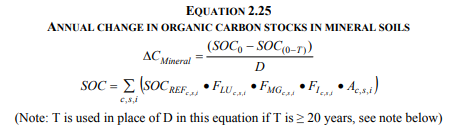
<br>

With: <br>
**SOCRef**: The reference carbon stock under a specific IPCC climate and soil type zone <br>
**FLU** : Stock change factor for land-use systems or sub-system for a particular land-use, dimensionless <br>
**FMG**: Stock change factor for management regime, dimensionless <br>
**FI**: Stock change factor for input of organic matter, dimensionless <br>
**D**: Time dependence of stock change factors which is the default time period for transition between equilibrium SOC values (usely 20 yrs) <br>

#### Define input folders and reference data

In [2]:
# the location of the basefolder in which all the input data needed for the simulation is provided
#!!!!!! Should be changed once know central location for data access
Basefolder_input_data = os.path.join(os.getcwd(), 'data')

### the basefolder in which all the output results will be stored
#!!!!!! Should be changed once know central location for data access
Basefolder_output =  os.path.join(os.getcwd(), 'output')

### the folder which provided the look-up-tables for converting the IPCC layers to stock change factors
### or a SOCref, this information is needed if not other high resolution data is available on SOC 
SOC_LUT_folder = os.path.join(Basefolder_input_data, 'SOC_LUT')

## the directory of the IPCC climate & soil raster that will be needed for the SOC scenarios and SOC ref calculation
IPCC_climate_raster = os.path.join(Basefolder_input_data, 'IPCC_layers', 'climate', 'ipcc_climate_zone_100m_EPSG3035_EEA39.tif') 
IPCC_soil_raster = os.path.join(Basefolder_input_data, 'IPCC_layers', 'soil', 'ipcc_soil_type_100m_EPSG3035_EEA39.tif') 

## location of the CLC map needed to calculate the FLU factor
CLC_ACC_folder = os.path.join(Basefolder_input_data, 'CLC_ACC')
CLC_ACC_layer = os.path.join(CLC_ACC_folder, 'CLC2018ACC_V2018_20.tif')


# location with the NUTS LEVEL 0 administrative boundaries
NUTS_layer = os.path.join(Basefolder_input_data, 'NUTS', 'NUTS_RG_20M_2021_3035.shp')

## location of the SOCref layer based on the IPCC soil and climate layers and using the LUT
SOCref_layer = os.path.join(Basefolder_output, 'SOC_REF', 'SOC_REF_IPCC_climate_soil_100m.tif')

### location of the code to run the scenarios
sys.path.append(Path(os.getcwd()).parent.joinpath('src').as_posix())
from SOC_scenarios.utils.soc_helper_functions import *


### Scenario definition 

The user will have the flexibility to define different scenarios for **FMG** & **FI**, options listed below:
Below some information on the possibilities:
 
##### FMG (Management) Cropland options:

1: Full tillage <br>
2: Reduced <br>
3: No-till <br>

##### FI (Input) Cropland options:

1: Low <br>
2: Medium <br>
3: High without manure <br>
4: High with manure <br>


##### FMG (Management) Grassland options:

1: Nominally managed <br>
2: Moderately degraded <br>
3: Severely degraded <br>
4: Improved grassland <br>


##### FI (Input) Grassland options:

1: Nominal <br>
2: High <br>



#### Define here the selected options per land use category:

In [3]:
#### the scenario settings to define
dict_stock_change_factors = {
    'Cropland': {'FMG': 3, 'FI': 4},
    'Grassland': {'FMG': 1, 'FI': 1}}

scenario_name = 'Scenario1' # this will be the suffix of the output scenario file

#### Specify area of interest
(running on the entire EEA39 extent is not recommended in a Notebook environment due to memory limitations!)

Options for selecting countries are the following ones:
'FR'
'HR'
'HU'
'AL'
'AT'
'BE'
'BG'
'CH'
'CY'
'CZ'
'DE'
'DK'
'EE'
'EL'
'IE'
'ES'
'FI'
'IS'
'PT'
'RO'
'RS'
'SE'
'SI'
'SK'
'TR'
'UK'
'NO'
'IT'
'LI'
'LT'
'LU'
'LV'
'ME'
'MK'
'MT'
'NL'
'PL'

In [4]:
#select now the country of interest
Country = 'FI'

## dictionary that will define all the flexible parameters that are set by the user
settings = {
    'Country': Country,
    'year_focus': 2018, # the reference year for the calculation
    'CLC_ACC_folder': CLC_ACC_folder,
    'Basefolder_input_data': Basefolder_input_data ,
    'Basefolder_output': Basefolder_output,
    'SOC_LUT_folder': SOC_LUT_folder,
    'Stock_change_scenario': dict_stock_change_factors, # the settings to create the stock change factors
    'Scaling': 100, # the factors of the IPCC LUT are multiplied by 100 to save memory ,
    'Scenario_name': scenario_name,
    'Fixed_factor_FMG': True,
    'Fixed_factor_FI': True,
    'overwrite': False
}

#### Clipping of reference layers to the desired AOI

In [5]:
### clip the CLC ACC layer to the country of interest
mask_raster_extent([CLC_ACC_layer], gpd.read_file(NUTS_layer)
                           , Path(CLC_ACC_layer).parent,settings,
                           overwrite=False, Country_clipping=True)

### Clip the SOCref to the proper extent
mask_raster_extent([SOCref_layer], gpd.read_file(NUTS_layer)
                           , Path(SOCref_layer).parent,settings,
                           overwrite=False, Country_clipping=True)

## Clipping of the IPCC climate layer
mask_raster_extent([IPCC_climate_raster], gpd.read_file(NUTS_layer)
                           , Path(IPCC_climate_raster).parent,settings,
                           overwrite=False, Country_clipping=True)

settings.update({'path_IPCC_climate_resampled': Path(glob.glob(os.path.join((Path(IPCC_climate_raster).parent).as_posix(),Country, '*.tif'))[0])})


#### Generation of stock change factor layer

In [6]:
###### FLU LAYER GENERATION
create_FLU_layer(SOC_LUT_folder,settings)


/usr/local/lib64/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
2022-08-31 08:40:51.199 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_FLU_layer:184 - CALCULATING FLU FACTOR FOR CLIMATE CATEGORY:1
 & LU CATEGORY:1
2022-08-31 08:40:51.285 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_FLU_layer:184 - CALCULATING FLU FACTOR FOR CLIMATE CATEGORY:2
 & LU CATEGORY:1
2022-08-31 08:40:51.370 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_FLU_layer:184 - CALCULATING FLU FACTOR FOR CLIMATE CATEGORY:3
 & LU CATEGORY:1
2022-08-31 08:40:51.480 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_FLU_layer:184 - CALCULATING FLU FACTOR FOR CLIMATE CATEGORY:4
 & LU CATEGORY:1
2022-08-31 08:40:51.565 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_FLU_layer:184 - CALCULATING FLU FACTO

In [7]:
###### FMG LAYER GENERATION
create_factor_layer(settings, type_factor='FMG'
                    ,fixed_factor_creation=settings.get('Fixed_factor_FMG'))

#### FI LAYER GENERATION
create_factor_layer(settings, type_factor='FI'
                    ,fixed_factor_creation=settings.get('Fixed_factor_FI'))



2022-08-31 08:41:04.595 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_factor_layer:287 - CALCULATING factor FOR LAND USE CATEGORY: Cropland
2022-08-31 08:41:04.600 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_factor_layer:295 - CALCULATING FMG FACTOR FOR FACTOR CATEGORY: 3 & CLIMATE ID: 1
2022-08-31 08:41:04.677 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_factor_layer:295 - CALCULATING FMG FACTOR FOR FACTOR CATEGORY: 3 & CLIMATE ID: 2
2022-08-31 08:41:04.754 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_factor_layer:295 - CALCULATING FMG FACTOR FOR FACTOR CATEGORY: 3 & CLIMATE ID: 3
2022-08-31 08:41:04.859 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_factor_layer:295 - CALCULATING FMG FACTOR FOR FACTOR CATEGORY: 3 & CLIMATE ID: 4
2022-08-31 08:41:04.950 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_factor_layer:295 - CALCULATING FMG FACTOR FOR FACTOR CATEGORY: 3 & CLIMATE ID: 7
2022-08-31 08:4

## SOC scenario calculation

**Unit**: tonnes C/pixel

In [8]:
### NOW THE FINAL SOC BASED ON THE DEFINED SCENARIO CAN BE CALCULATED
create_SOC_scenario_layer(settings)

2022-08-31 08:41:11.480 | INFO     | SOC_scenarios.utils.soc_helper_functions:create_SOC_scenario_layer:395 - CALCULATE SOCREF


### Visualize result

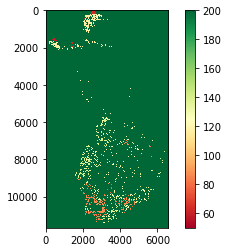

In [13]:
dir_SOC_scenario = os.path.join(os.getcwd(), 'output', 'SOC_scenario', Country,'SOC_{}_{}.tif'.format(scenario_name, Country))
SOC_outcome_array = rasterio.open(dir_SOC_scenario).read(1)

plt.imshow(SOC_outcome_array, cmap=plt.get_cmap('RdYlGn'),
               vmin=50, vmax=200)
plt.colorbar()